# Use Numba to Create Bifurcation Diagram for the DDP

## Create useful functions for finding $\theta(t)$ at each period

In [ ]:
%matplotlib notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import time
from numba import jit
#from numba.typed import List

A number of changes have been made to the code in our previous notebook.

- The previous notebook used a list to store $\theta$ and $\omega$ in each time step. In this notebook, the functions are rewritten to store $\theta$ and $\omega$ in a numpy array. 
- No global variables are used. Our `model_pendulum` function now takes a third argument `const` that is an array of the constants in the ODEs.
- The integrator function `RK4const` now takes a fourth argument `const` that is an array of the constants in the ODEs. It passes these constants to the model function.
- The model function is no longer an argument for the integrator function. Rather, the model function has been written explicitly into the integrator function. We lose generality, yes, but it may be necessary for `numba`.


In [3]:
def model_pendulum(y, t, const): # y=[theta,omega]; function returns [dtheta/dt, domega/dt]
    # const is an array with [gamma, beta, omega_0, omega_d]
    gamma = const[0]
    beta = const[1]
    omega_0 = const[2]
    omega_d = const[3]
    
    theta = y[0]
    omega = y[1]
    
    dtheta_dt = omega
    domega_dt = omega_0**2*gamma*np.cos(omega_d*t) - omega_0**2*np.sin(theta)-2*beta*omega
    
    return np.array([dtheta_dt, domega_dt])

def RK4const(y0, t, h, const):
    """ RK4 method for ODEs:
        Given y0 at t, returns y1 at t+h """
    k1 = h*model_pendulum(y0, t, const)                    # dy/dt at t
    k2 = h*model_pendulum(y0+0.5*k1, t + h/2., const)      # dy/dt at t+h/2
    k3 = h*model_pendulum(y0+0.5*k2, t + h/2., const)      # dy/dt at t+h/2
    k4 = h*model_pendulum(y0+k3, t + h, const)             # dy/dt at t+h
    return y0 + (k1+k4)/6.0 + (k2+k3)/3.0

def run_pendulum(gam=0.2, beta=3/4*np.pi, theta_i=0, omega_i=0, t_total = 10):
    
    omega_d = 2*np.pi
    omega_0 = 1.5*omega_d
    
    const = np.array([gam,beta,omega_0,omega_d])

    t = 0.0
    h = 0.001

    data = np.array([theta_i,omega_i])

    tdata = []
    thetadata = []
    omegadata = []
    Fddata = []

    tdata.append(t)
    thetadata.append(theta_i)
    omegadata.append(omega_i)
    Fddata.append(gam*np.cos(omega_d*t))

    while t < t_total:
        #integrate
        data = RK4const(data, t, h, const) #update y[n]

        t = t + h #update clock

        tdata.append(t)
        thetadata.append(data[0])
        omegadata.append(data[1])
        Fddata.append(gam*np.cos(omega_d*t))

    return np.array(tdata), np.array(thetadata), np.array(omegadata), np.array(Fddata)

def get_fixed_points(g = 1.06): #return thetas at N integer times in the steady state
    
    t_total = 600
    N_last_periods = 100

    tdata, thetadata, omegadata, Fddata = run_pendulum(g, 3/4*np.pi, -np.pi/2, 0, t_total)

    times = np.arange(500,600,1)
    thetas = []

    for t in times:
        index = np.abs(tdata-t).argmin()
        thetas.append(thetadata[index])

    return thetas

To find the attractors, call `get_fixed_points()` for a particular gamma. Plot the values of $\theta$ vs. $\gamma$, and increase gamma.

- Our constants are `global gam, beta, omega_0, omega_d`.
- Argument for `get_fixed_points()` is gamma. It returns an array of angles at equal time intervals (one period) after the initial transient.
- Use $\theta_i = -\pi/2$ and $\omega = 0$.
- Use `time.time()` before and after the `for` loop to calculate how long it takes to calculate data for the bifurcation diagram.

## Calculate fixed point for one value of gamma

In [4]:
gams = np.linspace(1.06,1.087,1)

thetadata = []
gamdata = []

start = time.time()
for g in gams:
    
    thetas = get_fixed_points(g)
    thetadata = thetadata + thetas
    
    gamdata = gamdata + (g*np.ones(len(thetas))).tolist()

end = time.time()

totaltime = end-start

print("loop time = ", totaltime)


loop time =  26.006107091903687


## Calculate fixed points for a range of gamma

Use a range of $1.0600<\gamma<1.0870$ in increments of 0.001. Plot the fixed points as a function of time. **This may take around 10 minutes to run.**

In [5]:
gams = np.arange(1.06,1.087,0.001)

thetadata = []
gamdata = []

start = time.time()
for g in gams:
    
    thetas = get_fixed_points(g)
    thetadata = thetadata + thetas
    
    gamdata = gamdata + (g*np.ones(len(thetas))).tolist()

end = time.time()

totaltime = end-start

print("loop time = ", totaltime)


loop time =  601.7222092151642


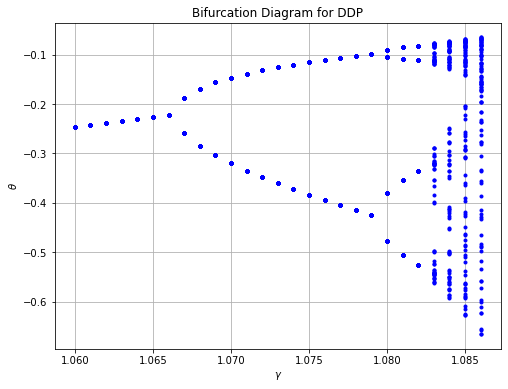

In [6]:
plt.figure(figsize=(8,6))
plt.title("Bifurcation Diagram for DDP")
plt.plot(gamdata,thetadata,'b.')
plt.xlabel("$\gamma$")
plt.ylabel("$\\theta$")
plt.grid(which='both', axis='both')
plt.show()

## Numba

Numba can be used to speed up the slowest parts of your code (generally `for` loops).

Here's a short blog article on [how to speed up your code with numba](https://towardsdatascience.com/heres-how-you-can-get-some-free-speed-on-your-python-code-with-numba-89fdc8249ef3).

Here's the [numba documentation](https://numba.pydata.org/numba-doc/dev/index.html). The [5-minute guide](https://numba.pydata.org/numba-doc/dev/user/5minguide.html) is a good place to start. According to the documentation:

    Numba is a just-in-time compiler for Python that works best on code that uses NumPy arrays and functions,
    and loops. The most common way to use Numba is through its collection of decorators that can be applied to
    your functions to instruct Numba to compile them. When a call is made to a Numba decorated function it is
    compiled to machine code “just-in-time” for execution and all or part of your code can subsequently run
    at native machine code speed!

In the program below, I have used the `@jit` decorator on all functions. Howevever, the greatest speedup will occur for the `run_pendulum` function.

In [15]:
@jit(nopython=True)
def model_pendulum_numba(y, t, const): # y=[theta,omega]; function returns [dtheta/dt, domega/dt]
    # const is an array with [gamma, beta, omega_0, omega_d]
    gamma = const[0]
    beta = const[1]
    omega_0 = const[2]
    omega_d = const[3]
    
    theta = y[0]
    omega = y[1]
    
    dtheta_dt = omega
    domega_dt = omega_0**2*gamma*np.cos(omega_d*t) - omega_0**2*np.sin(theta)-2*beta*omega
    
    return np.array([dtheta_dt, domega_dt])

@jit(nopython=True)
def RK4const_numba(y0, t, h, const):
    """ RK4 method for ODEs:
        Given y0 at t, returns y1 at t+h """
    k1 = h*model_pendulum_numba(y0, t, const)                    # dy/dt at t
    k2 = h*model_pendulum_numba(y0+0.5*k1, t + h/2., const)      # dy/dt at t+h/2
    k3 = h*model_pendulum_numba(y0+0.5*k2, t + h/2., const)      # dy/dt at t+h/2
    k4 = h*model_pendulum_numba(y0+k3, t + h, const)             # dy/dt at t+h
    return y0 + (k1+k4)/6.0 + (k2+k3)/3.0

@jit(nopython=True)
def run_pendulum_numba(gam=0.2, beta=3/4*np.pi, theta_i=0, omega_i=0, t_total = 10):
    
    omega_d = 2*np.pi
    omega_0 = 1.5*omega_d
    
    const = np.array([gam,beta,omega_0,omega_d])

    t = 0.0
    h = 0.001

    data = np.array([theta_i,omega_i])

    tdata = []
    thetadata = []
    omegadata = []
    Fddata = []

    tdata.append(t)
    thetadata.append(theta_i)
    omegadata.append(omega_i)
    Fddata.append(gam*np.cos(omega_d*t))

    while t < t_total:
        #integrate
        data = RK4const_numba(data, t, h, const) #update y[n]

        t = t + h #update clock

        tdata.append(t)
        thetadata.append(data[0])
        omegadata.append(data[1])
        Fddata.append(gam*np.cos(omega_d*t))

    return np.array(tdata), np.array(thetadata), np.array(omegadata), np.array(Fddata)

@jit(nopython=True)
def get_fixed_points_numba(g = 1.06): #return thetas at N integer times in the steady state
    
    t_total = 600
    N_last_periods = 100

    tdata, thetadata, omegadata, Fddata = run_pendulum_numba(g, 3/4*np.pi, -np.pi/2, 0, t_total)

    times = np.arange(500,600,1)
    thetas = []

    for t in times:
        index = np.abs(tdata-t).argmin()
        thetas.append(thetadata[index])

    return thetas

The `nopython` mode means that the code must be a subset of python. In general, `numpy` is supported very well. But not all python syntax is supported. For example, using global variables and passing a function name as an argument for a function may not be supported.

## Use numba to calculate fixed point for one value of gamma

In [16]:
gams = np.linspace(1.063,1.087,1)

thetadata = []
gamdata = []

start = time.time()
for g in gams:
    
    thetas = get_fixed_points_numba(g)
    thetadata = thetadata + thetas
    
    gamdata = gamdata + (g*np.ones(len(thetas))).tolist()

end = time.time()

totaltime = end-start

print("loop time = ", totaltime)


loop time =  6.099803924560547


Without numba, calculating the fixed points for one value of gamma took 23 s. With numba, it takes 3.1 s. That's a 7.4x improvement! 

## Use numba to calculate fixed point for a range of gammas

Now, run for more iterations of gamma. In this case, let's use approximately 250 iterations of gamma.

In [9]:
gams = np.arange(1.062,1.087,0.0001)

thetadata = []
gamdata = []

start = time.time()
for g in gams:
    
    thetas = get_fixed_points_numba(g)
    thetadata = thetadata + thetas
    
    gamdata = gamdata + (g*np.ones(len(thetas))).tolist()

end = time.time()

totaltime = end-start

print("loop time = ", totaltime)


loop time =  323.54025077819824


250 iterations with numba took approximately half the time as 27 iterations without numba.

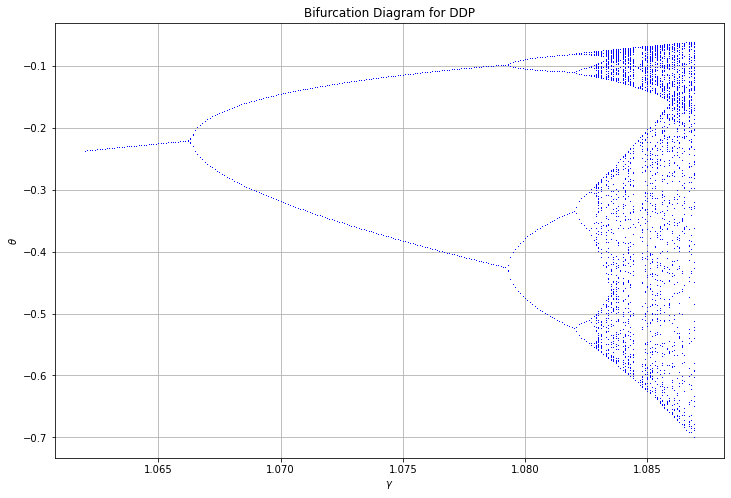

In [14]:
plt.figure(figsize=(12,8))
plt.title("Bifurcation Diagram for DDP")
plt.plot(gamdata,thetadata,'b,')
plt.xlabel("$\gamma$")
plt.ylabel("$\\theta$")
plt.grid(which='both', axis='both')
plt.savefig("DDP-bifurcation.png", dpi=100)
plt.show()

## Exercise 1

Which function benefits the most from from using `numba`? Remove the `@jit` decorator from all functions and then add it to only one function. Calculate the fixed point for one value of gamma. Repeat for all functions.

## Exercise 2

After reading the [documentation](https://numba.pydata.org/numba-doc/dev/user/5minguide.html), try other options to speed up the program. Report what gives you the best results.